# Chapter 6 [게이트가 추가된 RNN]
---
앞 장의 단순한 RNN은 시계열 데이터에서 시간적으로 멀리 떨어진, 장기 의존 관계를 잘 학습할 수 없다는 문제가 있습니다.  
LSTM, GRU 구조는 '게이트<sup>gate</sup>'라는 구조가 더해져 있는데, 이 게이트 덕분에 시계열 데이터의 장기 의존 관계를 학습할 수 있습니다.  

## 1. RNN의 문제점

### 기울기 소실 또는 기울기 폭발
---
<img src=img/fig6-5.png width='800'>  
RNN 계층에서 시간 방향으로 역전파 할 때 전해지는 기울기는 차례로 'tanh', '+', 'MatMul'연산을 통과합니다.
이 계층들이 기울기를 어떻게 변화시킬까요?

$ y = tanh(x) $일 때의 미분은 $ \frac{\partial y}{\partial x}=1-y^{2} $ 입니다. 이때 $ y = tanh(x) $의 값과 그 미분 값을 각각 그래프로 그리면 다음과 같습니다.  
<img src=img/fig6-6.png width='400'>  
점선이 $ y = tanh(x) $의 미분입니다. 보다시피 그 값은 1.0 이하이고, x가 0으로부터 멀어질수록 작아집니다.  
즉 역전파에서 기울기가 tanh 노드를 지날 때마다 값은 계속 작아진다는 뜻입니다.  

다음은 Matmul 노드 입니다.  
상류로부터 $ dh $라는 기울기가 흘러옵니다.  
이때 MatMul 노드에서의 역전파는 $ dhW_{n}^{T} $라는 행렬 곱으로 기울기를 계산합니다.  
그리고 같은 계산을 시계열 데이터의 시간 크기만큼 반복하죠. 그러면 역전파 시 기울기는 MatMul 노드를 지날 때마다 어떻게 변할까요?

[2.4684068094579303, 3.3357049741610365, 4.783279375373182, 6.279587332087612, 8.080776465019053, 10.251163032292936, 12.936063506609896, 16.276861327786712, 20.45482961834598, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.8244073070191, 63.79612654485427, 80.07737014308985, 100.5129892205125, 126.16331847536823, 158.35920648258823, 198.7710796761195, 249.495615421267]


C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 53356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 45432 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 47492 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-package

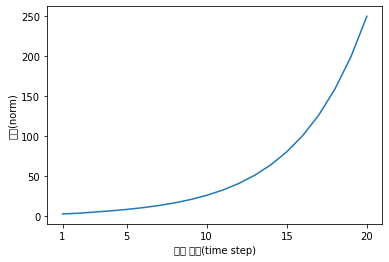

[165.82723327563536, 46.073751982593116, 39.33717299029768, 15.343673208370237, 13.427630740269848, 7.764749802532891, 5.710756601803507, 3.7195501552126626, 2.5825395665804947, 1.735482186197724, 1.1861180077280082, 0.8036560015488017, 0.5469555307956063, 0.3713955517070608, 0.2524843606451469, 0.17154116983311937, 0.11658374794484584, 0.07922054522299886, 0.0538360964803239, 0.03658396904103571]


C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 53356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 45432 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 47492 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda\lib\site-package

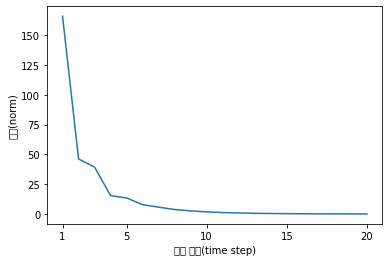

In [1]:
import numpy as np
import matplotlib.pyplot as plt


N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

그래프에서 보듯 기울기의 크기는 시간에 비례해 지수적으로 증가(폭발) 혹은 감소(소실)합니다.  
이러한 현상 때문에 장기 의존 관계를 학습할 수 없게 됩니다.  

### 기울기 폭발 대책
---
기울기 폭발의 대책으로는 **기울기 클리핑**<sup>gradients clipping</sup>이라는 전통적인 기법이 있습니다.  
그 알고리즘을 의사 코드로 쓰면 다음과 같습니다.  

$$ \large{\mathrm{ if\  \lVert \hat{\mathbf{g}} \lVert\ \ge\ threshold}}: $$  
$$ \large{\mathrm{ \hat{\mathbf{g}} = \frac{threshold}{\lVert \hat{\mathbf{g}} \lVert}\hat{\mathbf{g}}}} $$  

In [2]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

## 2. 기울기 소실과 LSTM

### LSTM의 인터페이스
---
LSTM 계층을 자세히 살펴보기 전에 계산 그래프를 단순화하는 도법을 사용하겠습니다.  
<img src=img/fig6-10.png width='800'>  
그림에서 $ tanh(h_{t-1}W_{h} + x_{t}W{x} + b) $ 계산을 tanh라는 직사각형 노드 하나로 그렸습니다.  

이제 LSTM과 RNN을 비교하는 것부터 시작해보겠습니다.  
<img src=img/fig6-11.png width='800'>  
그림처럼 LSTM 계층의 인터페이스에는 $c$라는 경로가 있다는 차이가 있습니다.  
이 $c$를 **기억 셀**<sup>memory cell</sup>이라 하며, LSTM 전용의 기억 메커니즘입니다.

기억 셀의 특징은 데이터를 자기 자신으로만(LSTM 계층 내에서만) 주고받는다는 것입니다.  
즉, LSTM 계층 내에서만 연결되고, 다른 계층으로는 출력하지 않습니다.  
LSTM의 은닉상태 h는 RNN 계층과 마찬가지로 다른 계층으로(위쪽으로) 출력됩니다.

### LSTM 계층 조립하기
---
LSTM의 부품을 하나씩 조립하면서, 그 구조를 차분히 알아보겠습니다.  

LSTM에는 기억 셀 $c_{t}$가 있습니다. 이 $c_{t}$에는 시각 $t$에서의 LSTM의 기억이 저장돼 있는데  
과거로부터 시각 $t$까지에 필요한 모든 정보가 저장돼 있다고 가정합니다. (혹은 그렇게 되도록 학습을 수행합니다.)  
그리고 필요한 정보를 모두 간직한 이 기억을 바탕으로, 외부 계층에(그리고 다음 시각의 LSTM에) 은닉 상태 $h_{t}$를 출력합니다.  
<img src=img/fig6-12.png width='500'>  
그림처럼 현재의 기억 셀 $c_{t}$는 3개의 입력($c_{t-1}, h_{t-1}, x_{t}$)으로부터 '어떤 계산'을 수행하여 구할 수 있습니다.

### output 게이트
---
이 게이트는 $tanh(c_{t})$의 각 원소에 대해 '그것이 다음 시각의 은닉 상태에 얼마나 중요한가'를 조정합니다.  
output 게이트의 열림 상태(다음 몇 %만 흘려보낼까)는 입력 $x_{t}$와 이전 상태 $h_{t-1}$로부터 구합니다.  
이때의 계산은 다음과 같습니다. 여기서 사용하는 가중치 매개변수와 편향에는 output의 첫 글자인 $o$를 첨자로 추가합니다.  
이후에도 마찬가지로 첨자를 붙여 게이트임을 표시하겠습니다. 한편, 시그모이드 함수는 $\sigma()$로 표기합니다.  

$$ \large{\mathrm{ o = \sigma(x_{t}W^{(o)}_{x} + h_{t-1}W^{(o)}_{h} + b^{(o)}) }} $$  
<img src=img/fig6-15.png width='500'>  
$\sigma$의 출력을 $o$라고 하면 $h_t$는 $o$와 $tanh(c_t)$의 곱으로 계산됩니다.  
여기서 말하는 '곱'이란 원소별 곱이며, 이것을 **아다마르 곱**<sup>Hadamard product</sup>이라고도 합니다.  
아다마르 곱은 기호로 $\odot$으로 나타내며, 다음과 같은 계산을 수행합니다.  

$$ \large{\mathrm{ h_{t} = o \odot tanh(c_{t}) }} $$  

### forget 게이트
---
망각은 더 나은 전진을 낳습니다. 우리가 다음에 해야 할 일은 기억 셀에 '무엇을 잊을까'를 명확하게 지시하는 것입니다.  
그러면 $c_{t-1}$의 기억 중에서 불필요한 기억을 잊게 해주는 게이트를 추가하고, 이를 **forget 게이트**(망각 게이트)라 부르도록 하겠습니다.  
<img src=img/fig6-16.png width='500'>  
$$ \large{\mathrm{ f = \sigma(x_{t}W^{(f)}_{x} + h_{t-1}W^{(f)}_{h} + b^{(f)}) }} $$  

### 새로운 기억 셀
---
forget 게이트를 거치면서 이전 시각의 기억 셀로부터 잊어야 할 기억이 삭제되었습니다.  
그런데 이 상태로는 기억 셀이 잊는 것밖에 하지 못하겠네요. 그래서 새로 기억해야 할 정보를 기억셀에 추가해야 합니다.  
<img src=img/fig6-17.png width='500'>  
$$ \large{\mathrm{ g = tanh(x_{t}W^{(g)}_{x} + h_{t-1}W^{(g)}_{h} + b^{(g)}) }} $$  

### input 게이트
---
마지막으로 $g$에 게이트를 하나 추가하겠습니다. 여기에서 새롭게 추가하는 게이트를 **input 게이트**(입력 게이트)라고 하겠습니다.  
<img src=img/fig6-18.png width='500'>  
input 게이트는 $g$의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단합니다.  
새 정보를 무비판적으로 수용하는게 아니라, 적절히 취사선택하는 것이 이 게이트의 역할입니다.  
다른 관점에서 보면, input 게이트에 의해 가중된 정보가 새로 추가되는 셈입니다.

$$ \large{\mathrm{ i = \sigma(x_{t}W^{(i)}_{x} + h_{t-1}W^{(i)}_{h} + b^{(i)}) }} $$  

### LSTM의 기울기 흐름
---
LSTM의 구조를 살표보았는데, 이것이 어떤 원리로 기울기 소실을 없애주는 걸까요?  
그 원리는 기억 셀 $c$의 역전파에 주목하면 보입니다.  
<img src=img/fig6-19.png width='800'>  
기억 셀의 역전파에서는 '+'와 'x'노드만을 지나게 됩니다.  
'+'노드는 상류에서 전해지는 기울기를 그대로 흘릴 뿐입니다. 따라서 기울기의 변화(감소)는 일어나지 않습니다.  

그럼 'x'노드가 남는데, 이 노드는 '행렬 곱'이 아닌 '원소별 곱(아다마르 곱)'을 계산합니다.  
LSTM의 역전파에서는 '행렬 곱'이 아닌 '원소별 곱'이 이뤄지고, 매 시각 다른 게이트 값을 이용해 원소별 곱을 계산합니다.  
이처럼 매번 새로운 게이트 값을 이용하므로 곱셈의 효과가 누적되지 않아 기울기 소실이 일어나지 않는 (혹은 일어나기 어려운) 것입니다.  

## 3. LSTM 구현
다음은 LSTM에서 수행하는 계산을 정리한 수식들입니다.  
$$ \large{\mathrm{ f = \sigma(x_{t}W^{(f)}_{x} + h_{t-1}W^{(f)}_{h} + b^{(f)}) }} $$
$$ \large{\mathrm{ g = tanh(x_{t}W^{(g)}_{x} + h_{t-1}W^{(g)}_{h} + b^{(g)}) }} $$
$$ \large{\mathrm{ i = \sigma(x_{t}W^{(i)}_{x} + h_{t-1}W^{(i)}_{h} + b^{(i)}) }} $$
$$ \large{\mathrm{ o = \sigma(x_{t}W^{(o)}_{x} + h_{t-1}W^{(o)}_{h} + b^{(o)}) }} $$

$$ \large{\mathrm{ c_{t} = f \odot c_{t-1} + g \odot i }} $$
$$ \large{\mathrm{ h_{t} = o \odot tanh(c_{t}) }} $$  

$\mathrm{f, g, i, o}$는 하나의 식으로 정리해 계산할 수 있습니다.  
<img src=img/fig6-20.png width='700'>  
4개의 가중치를 하나로 모을 수 있고, 그렇게 하면 원래 개별적으로 총 4번을 수행하던 아핀 변환을 단 1회의 계산으로 끝마칠 수 있습니다.  
<img src=img/fig6-21.png width='700'>  

In [3]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

## 4. Time LSTM 구현

In [4]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

## 5. LSTM을 사용한 언어 모델

언어 모델은 앞 챕터에서 구현한 모델에서 RNN계층이 LSTM계층으로 바뀐것이 유일한 차이점 입니다.  

In [5]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

### 학습 코드

In [6]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10002.16


KeyboardInterrupt: 

## 6. RNNLM 추가 개선

### LSTM 계층 다층화
---
<img src=img/fig6-29.png width='700'>  
지금까지 우리는 LSTM 계층을 1층만 사용했지만 이를 2층, 3층으로 여러 겹 쌓으면 언어 모델의 정확도가 향상되리라 기대할 수 있습니다.  

### 드롭아웃에 의한 과적합 억제
---
층을 깊게 쌓음으로써 표현력이 풍부한 모델을 만들 수 있죠. 그러나 이런 모델은 종종 **과적합**<sup>overfitting</sup>을 일으킵니다.  
과적합을 억제하는 전통적인 방법이 있습니다. '훈련 데이터의 양 늘리기'와 '모델의 복잡도 줄이기'가 있습니다.  
그 외에는 모델의 복잡도에 페널티를 주는 **정규화**도 효과적입니다.  
또, 드롭아웃 처럼 훈련 시 계층 내의 뉴런 몇개를 무작위로 무시하고 학습하는 방법도 일종의 정규화라고 할 수 있습니다.  
<img src=img/fig6-30.png width='600'>  
피드포워드 신경망에서는 드롭아웃 계층을 신경망의 진행방향에 삽입했습니다.  
그러나 LSTM은 진행방향(시계열 방향)으로 삽입하면 학습 시 시간의 흐름에 따라 정보가 사라질 수 있습니다.
따라서 드롭아웃 계층을 깊이 방향(상하 방향)으로 삽입하는 것이 좋습니다.
<img src=img/fig6-32.png width='600'>  
<img src=img/fig6-33.png width='600'>  
이렇게 구성하면 시간 방향으로 아무리 진행해도 정보를 잃지 않습니다.  

그런데 최근 연구에서는 RNN의 시간 방향 정규화를 목표로 하는 방법이 다양하게 제안되고 있습니다.  
이 **변형 드롭아웃**<sup>Variational Dropout</sup>을 제안했고, 시간방향으로 적용하는 데 성공했습니다.  
<img src=img/fig6-34.png width='600'>  

### 가중치 공유
---
언어 모델을 개선하는 아주 간단한 트릭 중 **가중치 공유**<sup>weight tying</sup>가 있습니다.  
그림에서 보듯 Embedding 계층과 Affine계층이 가중치를 공유합니다.  
그러면 학습하는 매개변수 수가 크게 줄어드는 동시에 정확도도 향상되는 일석이조의 기술입니다.  
매개변수 수가 줄어든다는 것은 학습하기가 쉬워지고, 과적합이 억제되는 혜택으로 이어집니다.  
<img src=img/fig6-35.png width='600'>  

### 개선된 RNNLM 구현
---
지금까지의 개선점 3가지를 사용하여 BetterRnnlm 클래스로 만들어 보겠습니다.  
<img src=img/fig6-36.png width='400'>  

In [7]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()


In [9]:
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

Done
| 에폭 1 |  반복 1 / 1327 | 시간 7[s] | 퍼플렉서티 9999.99


KeyboardInterrupt: 